In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

<h1>Data Prepare</h1>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('ijcai2016_taobao_1.csv', sep=r',', engine='python')

In [4]:
df.head()

,use_ID,sel_ID,ite_ID,cat_ID,act_ID,time
0,1980536,9666,1450952,1,0,20150826
1,1980536,9666,1450952,1,0,20150826
2,647747,9666,1450952,1,0,20150915
3,1980536,9666,1450952,1,0,20150823
4,183647,9525,578730,1,0,20150711


In [5]:
df.describe().apply(lambda s: s.apply('{0}'.format))

,use_ID,sel_ID,ite_ID,cat_ID,act_ID,time
count,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0
mean,1024665.8052680527,4550.214902149021,1203661.2412924129,1.0,0.1009310093100931,20150830.19217192
std,596919.0583544845,2805.703221327739,688457.0158119791,0.0,0.3012388556068006,116.58427140128536
min,13.0,60.0,2017.0,1.0,0.0,20150701.0
25%,505223.0,2258.0,594459.0,1.0,0.0,20150720.0
50%,1023194.0,4562.0,1250255.0,1.0,0.0,20150813.0
75%,1542806.0,6792.0,1784092.0,1.0,0.0,20150916.0
max,2063567.0,9995.0,2353171.0,1.0,1.0,20151130.0


In [6]:
data_click = df[['use_ID', 'ite_ID', 'act_ID']].loc[df['act_ID'] == 0]
data_click = data_click.drop_duplicates()

In [7]:
data_buy = df[['use_ID', 'ite_ID', 'act_ID']].loc[df['act_ID'] == 1]
data_buy = data_buy.drop_duplicates()

In [8]:
data_merge = pd.merge(data_click, data_buy, left_on=['use_ID','ite_ID'], right_on=['use_ID','ite_ID'], how = 'left')
data_merge.columns = ['use_ID', 'ite_ID', 'click', 'buy']
data_merge['click'] = data_merge['click'].replace(0, 1)
data_merge['buy'] = data_merge['buy'].fillna(0)

data_merge.head()

,use_ID,ite_ID,click,buy
0,1980536,1450952,1,0.0
1,647747,1450952,1,0.0
2,183647,578730,1,0.0
3,723956,28301,1,0.0
4,1781938,28301,1,0.0


In [9]:
data_click.shape , data_buy.shape, data_merge.shape

((66802, 3), (8391, 3), (66802, 4))

In [10]:
data_merge.loc[data_merge['buy'] == 0].shape, data_merge.loc[data_merge['buy'] == 1].shape

((64808, 4), (1994, 4))

<h2>Data splitting</h2>

In [11]:
x = data_merge.iloc[:, 0:-2].values
# y = data_merge.iloc[:,2:4].values
y = data_merge.iloc[:,3:4].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [12]:
print(x_train.shape, x_test.shape, x_val.shape)

(40080, 2) (13361, 2) (13361, 2)


In [13]:
print(y_train.shape, y_test.shape, y_val.shape)

(40080, 1) (13361, 1) (13361, 1)


In [14]:
num_users = 2353171+1
num_items = 2353171+1
num_users, num_items

(2353172, 2353172)

<h1>Config</h1>

In [15]:
from keras.layers import Embedding, Input, Dense, merge, Reshape, Flatten, Dropout
from keras.regularizers import l2
from keras.optimizers import Adagrad, Adam, SGD, RMSprop

layers = [30,20]
reg_layers=[0, 0]
num_layer = len(layers)
learning_rate = 10e-4
embedding_dim = 64

GMF

In [16]:
## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = tf.keras.layers.Input(shape=(2))

Embedding_User = Embedding(
    input_dim = num_users, 
    output_dim = 64, name = 'user_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), 
    input_length=None)

Embedding_Item = Embedding(
    input_dim = num_items, 
    output_dim = 64, 
    name = 'item_embedding',
    embeddings_initializer = 'uniform', 
    embeddings_regularizer = l2(reg_layers[0]), 
    input_length=None)

user_embedding = Embedding_User(inputs[:,0])
item_embedding = Embedding_Item(inputs[:,1])

user_latent = Flatten(name = 'user_latent')(user_embedding)
item_latent = Flatten(name = 'item_latent')(item_embedding)

vector = tf.keras.layers.Multiply()([user_latent, item_latent])
click_prediction = Dense(1, activation='sigmoid',use_bias=True, 
                         kernel_initializer='lecun_uniform', 
                         name = 'click_prediction')(vector)

outputs = click_prediction

In [17]:
## Compile model
# with strategy.scope():
model2 = keras.models.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', 
              metrics=["accuracy","mse"])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None,)]            0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None,)]            0           input_1[0][0]                    
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 64)           150603008   tf_op_layer_strided_slice[0][0]  
______________________________________________________________________________________________

In [18]:
history2 = model2.fit(x_train, y_train,
                      validation_data = (x_val, y_val),
                      batch_size=200, epochs=100)

Epoch 1/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6852 - accuracy: 0.9668 - mse: 0.2460 - val_loss: 0.6808 - val_accuracy: 0.9711 - val_mse: 0.2438
Epoch 2/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6780 - accuracy: 0.9701 - mse: 0.2424 - val_loss: 0.6754 - val_accuracy: 0.9711 - val_mse: 0.2411
Epoch 3/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6733 - accuracy: 0.9701 - mse: 0.2401 - val_loss: 0.6713 - val_accuracy: 0.9711 - val_mse: 0.2391
Epoch 4/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6696 - accuracy: 0.9701 - mse: 0.2382 - val_loss: 0.6679 - val_accuracy: 0.9711 - val_mse: 0.2374
Epoch 5/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6664 - accuracy: 0.9701 - mse: 0.2366 - val_loss: 0.6648 - val_accuracy: 0.9711 - val_mse: 0.2358
Epoch 6/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6635 - accuracy: 0.9701 - mse: 0.2352 - val_loss

MLP

In [19]:
## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = tf.keras.layers.Input(shape=(2))

Embedding_User = Embedding(
    input_dim = num_users, 
    output_dim = 64, name = 'user_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1, trainable=True)

Embedding_Item = Embedding(
    input_dim = num_items, 
    output_dim = 64, 
    name = 'item_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1, trainable=True)

user_latent = Flatten()(Embedding_User(inputs[:,0]))
item_latent = Flatten()(Embedding_Item(inputs[:,1]))

vector = tf.concat([user_latent, item_latent], -1)

for idx in range(0, num_layer):
    layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name = 'layer_1_%d' %idx)
    vector = layer(vector)

click_prediction = Dense(1, activation='sigmoid',use_bias=True, kernel_initializer='lecun_uniform', name = 'click_prediction')(vector)

outputs = click_prediction

In [20]:
## Compile model
# with strategy.scope():
model3 = keras.models.Model(inputs=inputs, outputs=outputs)
model3.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', 
              metrics=["accuracy","mse"])
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None,)]            0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_3 (Te [(None,)]            0           input_2[0][0]                    
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 64)           150603008   tf_op_layer_strided_slice_2[0][0]
____________________________________________________________________________________________

In [21]:
history3 = model3.fit(x_train, y_train, 
                      validation_data = (x_val, y_val),
                      batch_size=200, epochs=100)

Epoch 1/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6756 - accuracy: 0.9088 - mse: 0.2412 - val_loss: 0.6614 - val_accuracy: 0.9711 - val_mse: 0.2341
Epoch 2/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6502 - accuracy: 0.9701 - mse: 0.2286 - val_loss: 0.6394 - val_accuracy: 0.9711 - val_mse: 0.2232
Epoch 3/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6294 - accuracy: 0.9701 - mse: 0.2182 - val_loss: 0.6194 - val_accuracy: 0.9711 - val_mse: 0.2132
Epoch 4/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6099 - accuracy: 0.9701 - mse: 0.2085 - val_loss: 0.6003 - val_accuracy: 0.9711 - val_mse: 0.2037
Epoch 5/100
201/201 [==============================] - 1s 3ms/step - loss: 0.5912 - accuracy: 0.9701 - mse: 0.1992 - val_loss: 0.5817 - val_accuracy: 0.9711 - val_mse: 0.1946
Epoch 6/100
201/201 [==============================] - 1s 3ms/step - loss: 0.5729 - accuracy: 0.9701 - mse: 0.1902 - val_loss

NeuMF

In [22]:
j = (int)(64/3)

## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = tf.keras.layers.Input(shape=(2))

Embedding_User = Embedding(
    input_dim = num_users, 
    output_dim = 64, name = 'user_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1, trainable=True)

Embedding_User2 = Embedding(
    input_dim = num_users, 
    output_dim = 64, name = 'user_embedding2',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1, trainable=True)

user_latent = Flatten()(Embedding_User(inputs[:,0]))
item_latent = Flatten()(Embedding_Item(inputs[:,1]))

vector = tf.concat([user_latent[:,j:64], item_latent[:,j:64]], -1)

for idx in range(0, num_layer):
    layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name = 'layer_1_%d' %idx)
    vector = layer(vector)

vector_gmf = tf.keras.layers.Multiply()([user_latent[:,0:j], user_latent[:,0:j]])

concat_layer = tf.concat([vector, vector_gmf], -1)

click_prediction = Dense(1, activation='sigmoid',use_bias=True, 
                         kernel_initializer='lecun_uniform', 
                         name = 'click_prediction')(concat_layer)
outputs = click_prediction

In [23]:
## Compile model
# with strategy.scope():
model4 = keras.models.Model(inputs=inputs, outputs=outputs)
model4.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', 
              metrics=["accuracy","mse"])
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_4 (Te [(None,)]            0           input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_5 (Te [(None,)]            0           input_3[0][0]                    
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 64)           150603008   tf_op_layer_strided_slice_4[0][0]
____________________________________________________________________________________________

In [24]:
history4 = model4.fit(x_train, y_train,
                      validation_data = (x_val, y_val),
                      batch_size=200, epochs=100)

Epoch 1/100
201/201 [==============================] - 1s 4ms/step - loss: 0.6739 - accuracy: 0.9371 - mse: 0.2404 - val_loss: 0.6602 - val_accuracy: 0.9711 - val_mse: 0.2335
Epoch 2/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6495 - accuracy: 0.9701 - mse: 0.2282 - val_loss: 0.6386 - val_accuracy: 0.9711 - val_mse: 0.2228
Epoch 3/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6286 - accuracy: 0.9701 - mse: 0.2178 - val_loss: 0.6182 - val_accuracy: 0.9711 - val_mse: 0.2126
Epoch 4/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6086 - accuracy: 0.9701 - mse: 0.2079 - val_loss: 0.5984 - val_accuracy: 0.9711 - val_mse: 0.2028
Epoch 5/100
201/201 [==============================] - 1s 3ms/step - loss: 0.5890 - accuracy: 0.9701 - mse: 0.1982 - val_loss: 0.5789 - val_accuracy: 0.9711 - val_mse: 0.1932
Epoch 6/100
201/201 [==============================] - 1s 3ms/step - loss: 0.5697 - accuracy: 0.9701 - mse: 0.1887 - val_loss

<h1>My Method</h1>

In [25]:
## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = tf.keras.layers.Input(shape=(2))

Embedding_User = Embedding(
    input_dim = num_users, 
    output_dim = 64, name = 'user_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1, trainable=True)

Embedding_User2 = Embedding(
    input_dim = num_users, 
    output_dim = 64, name = 'user_embedding2',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1, trainable=True)

user_latent = Flatten()(Embedding_User(inputs[:,0]))
item_latent = Flatten()(Embedding_Item(inputs[:,1]))

vector = tf.concat([user_latent, item_latent], -1)

for idx in range(0, num_layer):
    layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name = 'layer_1_%d' %idx)
    vector = layer(vector)

vector_gmf = tf.keras.layers.Multiply()([user_latent, user_latent])

concat_layer = tf.concat([vector, vector_gmf], -1)

click_prediction = Dense(1, activation='sigmoid',use_bias=True, 
                         kernel_initializer='lecun_uniform', 
                         name = 'click_prediction')(concat_layer)
outputs = click_prediction

In [26]:
## Compile model
# with strategy.scope():
model5 = keras.models.Model(inputs=inputs, outputs=outputs)
model5.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', 
              metrics=["accuracy","mse"])
model5.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_10 (T [(None,)]            0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_11 (T [(None,)]            0           input_4[0][0]                    
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 64)           150603008   tf_op_layer_strided_slice_10[0][0
____________________________________________________________________________________________

In [27]:
history5 = model5.fit(x_train, y_train,
                      validation_data = (x_val, y_val),
                      batch_size=200, epochs=100)

Epoch 1/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6753 - accuracy: 0.9654 - mse: 0.2411 - val_loss: 0.6643 - val_accuracy: 0.9711 - val_mse: 0.2356
Epoch 2/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6548 - accuracy: 0.9701 - mse: 0.2308 - val_loss: 0.6450 - val_accuracy: 0.9711 - val_mse: 0.2260
Epoch 3/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6359 - accuracy: 0.9701 - mse: 0.2214 - val_loss: 0.6262 - val_accuracy: 0.9711 - val_mse: 0.2166
Epoch 4/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6172 - accuracy: 0.9701 - mse: 0.2121 - val_loss: 0.6076 - val_accuracy: 0.9711 - val_mse: 0.2073
Epoch 5/100
201/201 [==============================] - 1s 3ms/step - loss: 0.5986 - accuracy: 0.9701 - mse: 0.2029 - val_loss: 0.5890 - val_accuracy: 0.9711 - val_mse: 0.1982
Epoch 6/100
201/201 [==============================] - 1s 3ms/step - loss: 0.5801 - accuracy: 0.9701 - mse: 0.1938 - val_loss

Evaluate

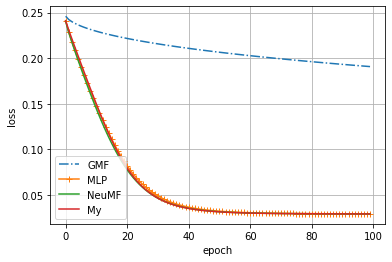

In [28]:
import matplotlib.pyplot as plt

# summarize history for accuracy
# plt.plot(history.history['root_mean_squared_error'])
plt.plot(history2.history['mse'],'-.')
plt.plot(history3.history['mse'],'-+')
plt.plot(history4.history['mse'],'-')
plt.plot(history5.history['mse'],'-')

# plt.plot(history.history['loss'])
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['GMF', 'MLP', 'NeuMF', 'My'], loc='lower left')
plt.show()

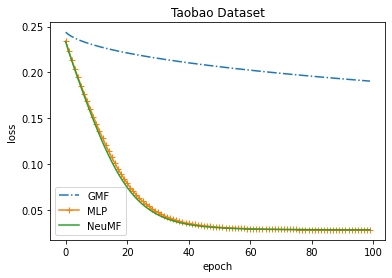

In [29]:
import matplotlib.pyplot as plt

# summarize history for accuracy
# plt.plot(history.history['root_mean_squared_error'])
plt.plot(history2.history['val_mse'],'-.')
plt.plot(history3.history['val_mse'],'-+')
plt.plot(history4.history['val_mse'],'-')

# plt.plot(history.history['loss'])
plt.title('Taobao Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower left')
plt.show()

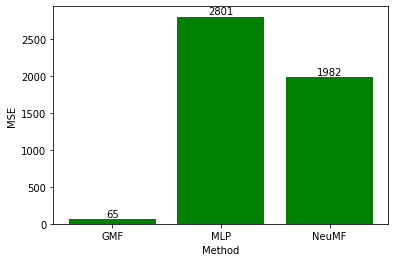

In [30]:
import matplotlib.pyplot as plt
labels = ['GMF', 'MLP', 'NeuMF']

energy = [
    65
    , 2801
    , 1982
]

# Plot the bar graph
plot = plt.bar(labels, energy, color='green')

# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x()+value.get_width()/2.,1.002*height,'%d'%int(height),ha='center',va='bottom')
plt.xlabel("Method")
plt.ylabel("MSE")
# Display the graph on the screen
plt.show()

In [31]:
test1 = model2.evaluate(x_test, y_test)
test2 = model3.evaluate(x_test, y_test)
test3 = model4.evaluate(x_test, y_test)

418/418 [==============================] - 1s 1ms/step - loss: 0.1372 - accuracy: 0.9693 - mse: 0.0297


In [32]:
print(test1[2], test2[2], test3[2])

0.19072198867797852 0.029772626236081123 0.029742861166596413


In [33]:
energy = [
#     history.history['root_mean_squared_error'][99]
    history2.history['val_mse'][99]
    , history3.history['val_mse'][99]
    , history4.history['val_mse'][99]
]
energy

[0.19048172235488892, 0.028142251074314117, 0.02806362695991993]

In [34]:
n = len(data_merge['ite_ID'].unique())
u = np.full((n, ), 1)
i = np.arange(n)
testsss = np.stack((u, i), axis=-1)

In [35]:
model3.predict(testsss).shape

(5461, 1)

In [39]:
np.min(model3.predict(testsss))

0.03157367

In [37]:
np.min(y)

0.0